<a href="https://colab.research.google.com/github/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/blob/main/PyTorch_FGSM_Adversarial_Attack_using_ImageNet_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [1]:
!git clone https://github.com/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST
%cd PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets

Cloning into 'PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST'...
remote: Enumerating objects: 6014, done.
remote: Total 6014 (delta 0), reused 0 (delta 0), pack-reused 6014
Receiving objects: 100% (6014/6014), 624.06 MiB | 51.31 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (5002/5002), done.
/content/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets


In [2]:
# load required PyTorch libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>Load ImageNet Classes</b>

In [4]:
from urllib.request import urlretrieve
import json

# load 1,000 labels from the ImageNet config file
with open('./imagenet.json') as f:
    imagenet_labels = json.load(f)

print(imagenet_labels[18])

magpie


#### <b>Image Visualization</b>

In [5]:
imsize = 224

preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)), # resize the image size
    transforms.ToTensor(), # [0, 255] → [0, 1] torch.Tensor
])

In [6]:
# load an image visualization library
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [7]:
# load an image and get a torch.Tensor object
def image_loader(path):
    image = PIL.Image.open(path)
    image = preprocess(image).unsqueeze(0) # [1, 3, H, W]
    return image.to(device, torch.float) # GPU로 올리기

In [8]:
image = image_loader('./ILSVRC2012_img_val_subset/18/ILSVRC2012_val_00000476.JPEG')

In [9]:
# show torch.Tensor image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # [3, H, W]
    image = transforms.ToPILImage()(image)
    # show an image whose values are between [0, 1]
    plt.imshow(image)
    plt.show()

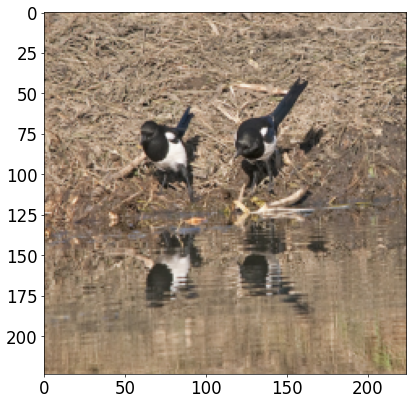

In [10]:
imshow(image)

#### <b>Load Pre-trained Classification Model</b>

In [11]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [12]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
).to(device).eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [13]:
outputs = model(image)
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print("< Highest Confidence Classes >")
for i in outputs[0].topk(5)[1]:
    print(f"Index: {i.item()} / Class name: {imagenet_labels[i]} / Probability: {round(percentages[i].item(), 4)}%")

< Highest Confidence Classes >
Index: 18 / Class name: magpie / Probability: 76.3741%
Index: 80 / Class name: black grouse / Probability: 17.3179%
Index: 137 / Class name: American coot, marsh hen, mud hen, water hen, Fulica americana / Probability: 1.0765%
Index: 93 / Class name: hornbill / Probability: 0.6028%
Index: 128 / Class name: black stork, Ciconia nigra / Probability: 0.5908%


#### <b>Load Full Validation Dataset</b>

In [14]:
import os
from torchvision import datasets

data_dir = './ILSVRC2012_img_val_subset'

val_datasets = datasets.ImageFolder(os.path.join(data_dir), preprocess)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=16, shuffle=True, num_workers=4)
print('Validation dataset size:', len(val_datasets))

class_names = val_datasets.classes
print('The number of classes:', len(class_names))

Validation dataset size: 5000
The number of classes: 1000


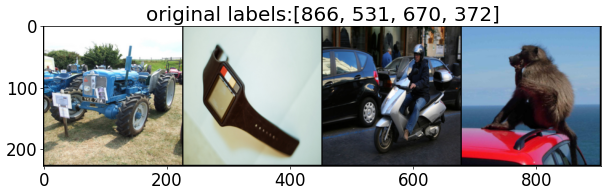

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: tractor (866)
Image #2: digital watch (531)
Image #3: motor scooter, scooter (670)
Image #4: baboon (372)


In [15]:
import torchvision
import numpy as np


def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of validation image
iterator = iter(val_dataloader)

# visualize a batch of validation image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([int(class_names[x]) for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, x in enumerate(classes[:4]):
    imagenet_index = int(class_names[x])
    label = imagenet_labels[imagenet_index]
    print(f'Image #{i + 1}: {label} ({imagenet_index})')

#### <b>Validation Phase</b>

[Prediction Result Examples]


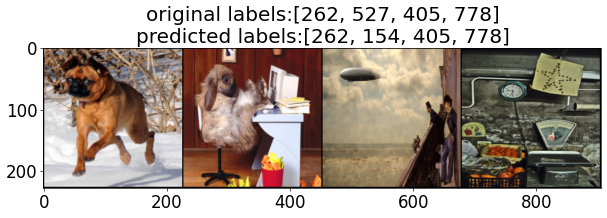

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Brabancon griffon (262)
Image #2: desktop computer (527)
Image #3: airship, dirigible (405)
Image #4: scale, weighing machine (778)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Brabancon griffon (262)
Image #2: Pekinese, Pekingese, Peke (154)
Image #3: airship, dirigible (405)
Image #4: scale, weighing machine (778)


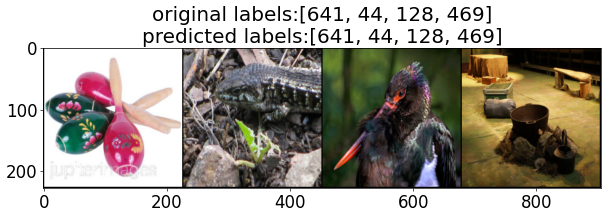

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: maraca (641)
Image #6: alligator lizard (44)
Image #7: black stork, Ciconia nigra (128)
Image #8: caldron, cauldron (469)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: maraca (641)
Image #6: alligator lizard (44)
Image #7: black stork, Ciconia nigra (128)
Image #8: caldron, cauldron (469)
[Validation] Loss: 0.0619 Accuracy: 76.0600% Time elapsed: 32.8865s (total 5000 images)


In [16]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

    epoch_loss = running_loss / len(val_datasets)
    epoch_acc = running_corrects / len(val_datasets) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_datasets)))

#### <b>Prepare Adversarial Attack Libraries</b>

In [18]:
!pip install foolbox
!pip install advertorch

In [19]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 1 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


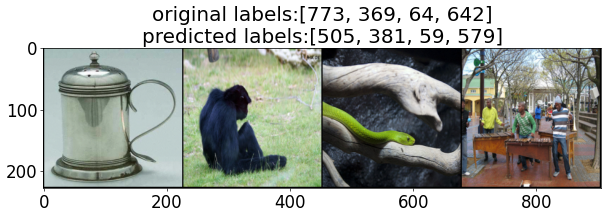

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: saltshaker, salt shaker (773)
Image #2: siamang, Hylobates syndactylus, Symphalangus syndactylus (369)
Image #3: green mamba (64)
Image #4: marimba, xylophone (642)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: coffeepot (505)
Image #2: spider monkey, Ateles geoffroyi (381)
Image #3: vine snake (59)
Image #4: grand piano, grand (579)


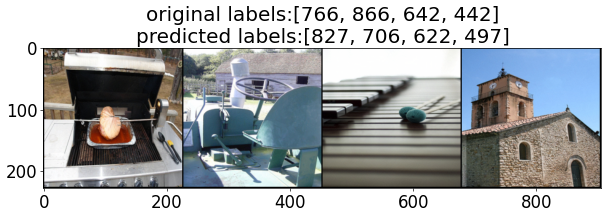

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: rotisserie (766)
Image #6: tractor (866)
Image #7: marimba, xylophone (642)
Image #8: bell cote, bell cot (442)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: stove (827)
Image #6: patio, terrace (706)
Image #7: lens cap, lens cover (622)
Image #8: church, church building (497)
[Step #0] Loss: 0.4544 Accuracy: 0.0000% Time elapsed: 1.4890s (total 16 images)
[Step #10] Loss: 0.4025 Accuracy: 11.3636% Time elapsed: 3.5251s (total 176 images)
[Step #20] Loss: 0.4006 Accuracy: 10.4167% Time elapsed: 5.5552s (total 336 images)
[Step #30] Loss: 0.4170 Accuracy: 10.2823% Time elapsed: 7.5974s (total 496 images)
[Step #40] Loss: 0.4191 Accuracy: 10.2134% Time elapsed: 9.6331s (total 656 images)
[Step #50] Loss: 0.4129 Accuracy: 11.0294% Time elapsed: 11.6653s (total 816 images)
[Step #60] Loss: 0.4097 Accuracy: 10.7582% Time elapsed: 13.6973s (total 976 images)
[Step #70] Loss: 0.4099 Accuracy: 11.0915% Time elapsed: 15.7297s (total 113

In [20]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=1/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_datasets)
epoch_acc = running_corrects / len(val_datasets) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_datasets)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_datasets))
print('Average L2 distance:', running_l2 / len(val_datasets))
print('Average MSE:', running_mse / len(val_datasets))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_datasets))

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 2 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


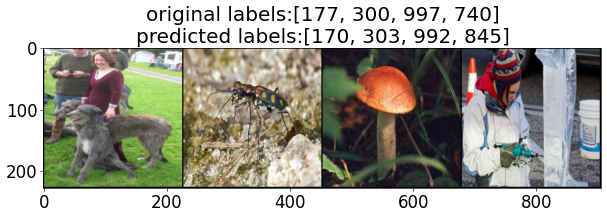

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Scottish deerhound, deerhound (177)
Image #2: tiger beetle (300)
Image #3: bolete (997)
Image #4: power drill (740)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Irish wolfhound (170)
Image #2: long-horned beetle, longicorn, longicorn beetle (303)
Image #3: agaric (992)
Image #4: syringe (845)


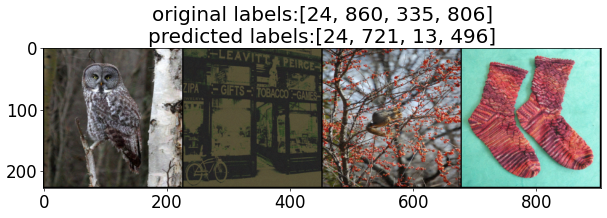

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: great grey owl, great gray owl, Strix nebulosa (24)
Image #6: tobacco shop, tobacconist shop, tobacconist (860)
Image #7: fox squirrel, eastern fox squirrel, Sciurus niger (335)
Image #8: sock (806)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: great grey owl, great gray owl, Strix nebulosa (24)
Image #6: pillow (721)
Image #7: junco, snowbird (13)
Image #8: Christmas stocking (496)
[Step #0] Loss: 0.4388 Accuracy: 6.2500% Time elapsed: 1.3840s (total 16 images)
[Step #10] Loss: 0.4243 Accuracy: 6.8182% Time elapsed: 3.4731s (total 176 images)
[Step #20] Loss: 0.4553 Accuracy: 6.2500% Time elapsed: 5.5500s (total 336 images)
[Step #30] Loss: 0.4511 Accuracy: 6.8548% Time elapsed: 7.6222s (total 496 images)
[Step #40] Loss: 0.4547 Accuracy: 6.7073% Time elapsed: 9.6894s (total 656 images)
[Step #50] Loss: 0.4647 Accuracy: 6.3725% Time elapsed: 11.7614s (total 816 images)
[Step #60] Loss: 0.4664 Accuracy: 6.2500% Time elapsed: 13

In [21]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=2/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_datasets)
epoch_acc = running_corrects / len(val_datasets) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_datasets)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_datasets))
print('Average L2 distance:', running_l2 / len(val_datasets))
print('Average MSE:', running_mse / len(val_datasets))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_datasets))

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 4 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


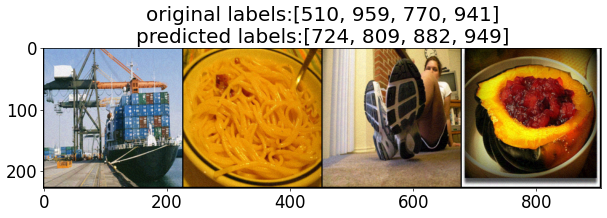

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: container ship, containership, container vessel (510)
Image #2: carbonara (959)
Image #3: running shoe (770)
Image #4: acorn squash (941)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: pirate, pirate ship (724)
Image #2: soup bowl (809)
Image #3: vacuum, vacuum cleaner (882)
Image #4: strawberry (949)


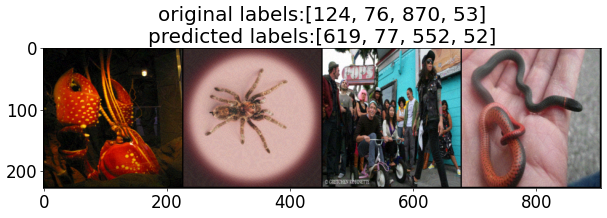

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: crayfish, crawfish, crawdad, crawdaddy (124)
Image #6: tarantula (76)
Image #7: tricycle, trike, velocipede (870)
Image #8: ringneck snake, ring-necked snake, ring snake (53)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: lampshade, lamp shade (619)
Image #6: wolf spider, hunting spider (77)
Image #7: feather boa, boa (552)
Image #8: thunder snake, worm snake, Carphophis amoenus (52)
[Step #0] Loss: 0.4833 Accuracy: 6.2500% Time elapsed: 1.3767s (total 16 images)
[Step #10] Loss: 0.5047 Accuracy: 2.8409% Time elapsed: 3.4969s (total 176 images)
[Step #20] Loss: 0.5003 Accuracy: 4.4643% Time elapsed: 5.6201s (total 336 images)
[Step #30] Loss: 0.4904 Accuracy: 4.0323% Time elapsed: 7.7473s (total 496 images)
[Step #40] Loss: 0.4924 Accuracy: 3.6585% Time elapsed: 9.8780s (total 656 images)
[Step #50] Loss: 0.4898 Accuracy: 3.7990% Time elapsed: 12.0088s (total 816 images)
[Step #60] Loss: 0.4814 Accuracy: 4.4057% Time elapsed: 14

In [22]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=4/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_datasets)
epoch_acc = running_corrects / len(val_datasets) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_datasets)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_datasets))
print('Average L2 distance:', running_l2 / len(val_datasets))
print('Average MSE:', running_mse / len(val_datasets))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_datasets))

#### <b>Adversarial Attack Example 4</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 8 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


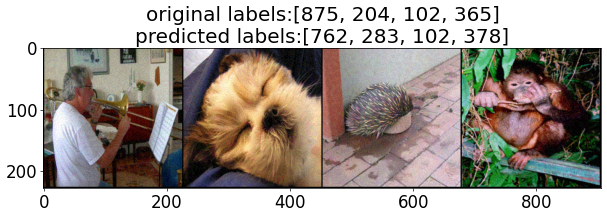

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: trombone (875)
Image #2: Lhasa, Lhasa apso (204)
Image #3: echidna, spiny anteater, anteater (102)
Image #4: orangutan, orang, orangutang, Pongo pygmaeus (365)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: restaurant, eating house, eating place, eatery (762)
Image #2: Persian cat (283)
Image #3: echidna, spiny anteater, anteater (102)
Image #4: capuchin, ringtail, Cebus capucinus (378)


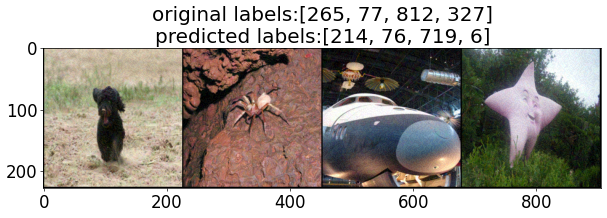

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: toy poodle (265)
Image #6: wolf spider, hunting spider (77)
Image #7: space shuttle (812)
Image #8: starfish, sea star (327)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: Gordon setter (214)
Image #6: tarantula (76)
Image #7: piggy bank, penny bank (719)
Image #8: stingray (6)
[Step #0] Loss: 0.3998 Accuracy: 12.5000% Time elapsed: 1.3723s (total 16 images)
[Step #10] Loss: 0.4229 Accuracy: 6.2500% Time elapsed: 3.5268s (total 176 images)
[Step #20] Loss: 0.4497 Accuracy: 7.4405% Time elapsed: 5.6761s (total 336 images)
[Step #30] Loss: 0.4527 Accuracy: 6.0484% Time elapsed: 7.8287s (total 496 images)
[Step #40] Loss: 0.4458 Accuracy: 6.0976% Time elapsed: 9.9772s (total 656 images)
[Step #50] Loss: 0.4422 Accuracy: 6.1275% Time elapsed: 12.1216s (total 816 images)
[Step #60] Loss: 0.4391 Accuracy: 6.3525% Time elapsed: 14.2683s (total 976 images)
[Step #70] Loss: 0.4437 Accuracy: 6.2500% Time elapsed: 16.4244s (total 1136 imag

In [23]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=8/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_datasets)
epoch_acc = running_corrects / len(val_datasets) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_datasets)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_datasets))
print('Average L2 distance:', running_l2 / len(val_datasets))
print('Average MSE:', running_mse / len(val_datasets))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_datasets))

#### <b>Adversarial Attack Example 5</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 16 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


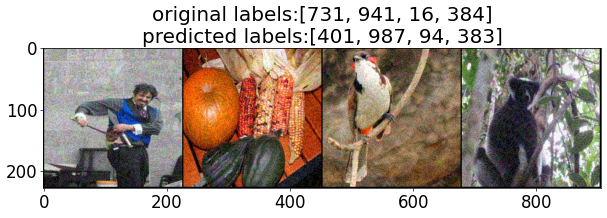

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: plunger, plumber's helper (731)
Image #2: acorn squash (941)
Image #3: bulbul (16)
Image #4: indri, indris, Indri indri, Indri brevicaudatus (384)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: accordion, piano accordion, squeeze box (401)
Image #2: corn (987)
Image #3: hummingbird (94)
Image #4: Madagascar cat, ring-tailed lemur, Lemur catta (383)


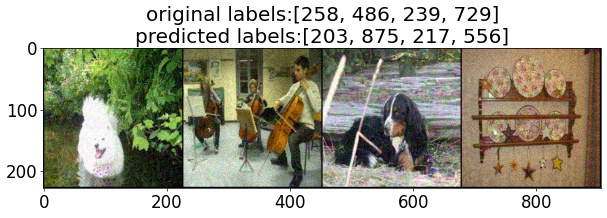

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: Samoyed, Samoyede (258)
Image #6: cello, violoncello (486)
Image #7: Bernese mountain dog (239)
Image #8: plate rack (729)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: West Highland white terrier (203)
Image #6: trombone (875)
Image #7: English springer, English springer spaniel (217)
Image #8: fire screen, fireguard (556)
[Step #0] Loss: 0.4577 Accuracy: 0.0000% Time elapsed: 1.3333s (total 16 images)
[Step #10] Loss: 0.4067 Accuracy: 9.6591% Time elapsed: 3.4883s (total 176 images)
[Step #20] Loss: 0.4023 Accuracy: 9.2262% Time elapsed: 5.6318s (total 336 images)
[Step #30] Loss: 0.3906 Accuracy: 10.2823% Time elapsed: 7.7832s (total 496 images)
[Step #40] Loss: 0.3971 Accuracy: 8.9939% Time elapsed: 9.9388s (total 656 images)
[Step #50] Loss: 0.4004 Accuracy: 9.0686% Time elapsed: 12.0860s (total 816 images)
[Step #60] Loss: 0.3983 Accuracy: 9.6311% Time elapsed: 14.2329s (total 976 images)
[Step #70] Loss: 0.3934 Accuracy:

In [24]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=16/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_datasets)
epoch_acc = running_corrects / len(val_datasets) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_datasets)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_datasets))
print('Average L2 distance:', running_l2 / len(val_datasets))
print('Average MSE:', running_mse / len(val_datasets))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_datasets))

#### <b>Adversarial Attack Example 6</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 32 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


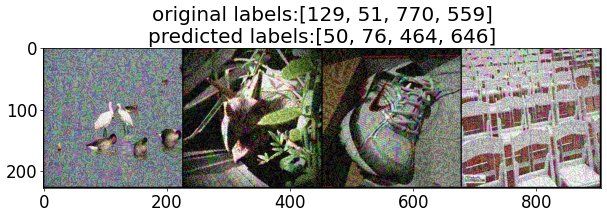

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: spoonbill (129)
Image #2: triceratops (51)
Image #3: running shoe (770)
Image #4: folding chair (559)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: American alligator, Alligator mississipiensis (50)
Image #2: tarantula (76)
Image #3: buckle (464)
Image #4: maze, labyrinth (646)


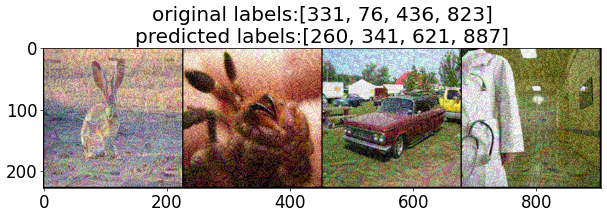

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: hare (331)
Image #6: tarantula (76)
Image #7: beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon (436)
Image #8: stethoscope (823)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: chow, chow chow (260)
Image #6: hog, pig, grunter, squealer, Sus scrofa (341)
Image #7: lawn mower, mower (621)
Image #8: vestment (887)
[Step #0] Loss: 0.4174 Accuracy: 0.0000% Time elapsed: 1.3319s (total 16 images)
[Step #10] Loss: 0.3843 Accuracy: 7.9545% Time elapsed: 3.4926s (total 176 images)
[Step #20] Loss: 0.3977 Accuracy: 6.5476% Time elapsed: 5.6470s (total 336 images)
[Step #30] Loss: 0.3975 Accuracy: 6.8548% Time elapsed: 7.8067s (total 496 images)
[Step #40] Loss: 0.3877 Accuracy: 7.1646% Time elapsed: 9.9540s (total 656 images)
[Step #50] Loss: 0.3865 Accuracy: 7.8431% Time elapsed: 12.1176s (total 816 images)
[Step #60] Loss: 0.3885 Accuracy: 7.5820% Time elapsed: 14.2617s (total 976 images)
[Step #70] Lo

In [25]:
import time
from advertorch.attacks import GradientSignAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=32/255, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_datasets)
epoch_acc = running_corrects / len(val_datasets) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_datasets)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_datasets))
print('Average L2 distance:', running_l2 / len(val_datasets))
print('Average MSE:', running_mse / len(val_datasets))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_datasets))

#### <b>Comparison with Foolbox</b>

* <b>Attack method</b>: FGSM
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 32 / 255
* FGSM is similar to 1-step PGD attack.

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


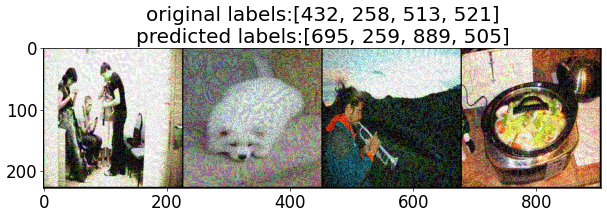

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: bassoon (432)
Image #2: Samoyed, Samoyede (258)
Image #3: cornet, horn, trumpet, trump (513)
Image #4: Crock Pot (521)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: padlock (695)
Image #2: Pomeranian (259)
Image #3: violin, fiddle (889)
Image #4: coffeepot (505)


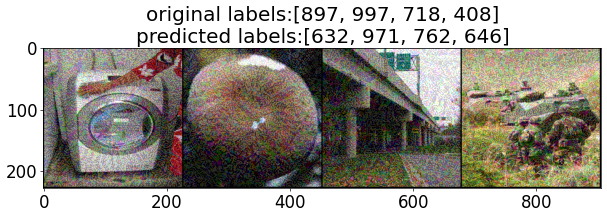

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: washer, automatic washer, washing machine (897)
Image #6: bolete (997)
Image #7: pier (718)
Image #8: amphibian, amphibious vehicle (408)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: loudspeaker, speaker, speaker unit, loudspeaker system, speaker system (632)
Image #6: bubble (971)
Image #7: restaurant, eating house, eating place, eatery (762)
Image #8: maze, labyrinth (646)
[Step #0] Loss: 0.4108 Accuracy: 0.0000% Time elapsed: 1.5229s (total 16 images)
[Step #10] Loss: 0.3962 Accuracy: 6.8182% Time elapsed: 4.1699s (total 176 images)
[Step #20] Loss: 0.3954 Accuracy: 6.8452% Time elapsed: 6.8231s (total 336 images)
[Step #30] Loss: 0.3910 Accuracy: 6.2500% Time elapsed: 9.4746s (total 496 images)
[Step #40] Loss: 0.3931 Accuracy: 7.1646% Time elapsed: 12.1258s (total 656 images)
[Step #50] Loss: 0.3932 Accuracy: 7.7206% Time elapsed: 14.7831s (total 816 images)
[Step #60] Loss: 0.3968 Accuracy: 7.3770% Time elapsed: 17.4481s

In [26]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.LinfFastGradientAttack()

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    _, adv_untargeted, _ = attack(fmodel, inputs, labels, epsilons=32/255) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_datasets)
epoch_acc = running_corrects / len(val_datasets) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_datasets)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_datasets))
print('Average L2 distance:', running_l2 / len(val_datasets))
print('Average MSE:', running_mse / len(val_datasets))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_datasets))